## Importing Libraries

In [3]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
# from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, os, copy, argparse
import multiprocessing
from torchsummary import summary
from matplotlib import pyplot as plt
from PIL import Image

In [4]:
# buat variabel train, validasi dan test dari path dataset
train_dir = '../dataset/train'
val_dir = '../dataset/val'
test_dir = '../dataset/test'

In [5]:
# Membuat variabel untuk banyak epoch
num_epochs = 25

# Membuat variabel untuk batch size
batch_size = 4

# variabel untuk jumlah kelas percobaan
num_classes = 4

# variabel untuk num_workers dimana memberitahukan berapa banyak sub-proses yang digunakan untuk memuat data
num_cpu = multiprocessing.cpu_count()

## **Menghitung nilai rata-rata (mean) dan standar deviasi (std) untuk dilakukan normalisasi gambar**

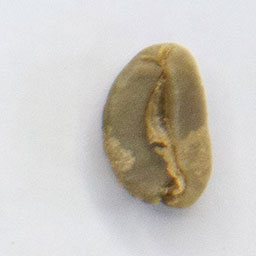

In [6]:
# load dan menampilkan contoh gambar biji kopi yang akan dihitung

# Memuat gambar
path_base ='../dataset/train'
img_path = path_base + '/longberry/1010.jpg'
img = Image.open(img_path)
img

In [7]:
# Mengonversi gambar PIL ke numpy array
img_np = np.array(img)


# # Membuat plot nilai setiap pixel gambar
# plt.hist(img_np.ravel(), bins=50, density=True)
# plt.xlabel("nilai pixel")
# plt.ylabel("frekuensi")
# plt.title("distribusi dari setiap pixel")

In [8]:
# membuat tansforms gambar ke Pytorch tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# melakukan transform dari gambar PIL ke tensor
img_tr = transform(img)

# mengonversi gambar tensor ke numpy array
img_np = np.array(img_tr)

# # Membuat plot nilai setiap pixel gambar
# plt.hist(img_np.ravel(), bins=50, density=True)
# plt.xlabel("nilai pixel")
# plt.ylabel("frekuensi")
# plt.title("distribusi dari setiap pixel")

In [9]:
# menghitung nilai rata-rata (mean) dan standar deviasi (std)

# Gambar tensor
img_tr = transform(img)

# Menghitung mean dan std
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])

# mencetak hasil kalkulasi
print("nilai rata-rata (mean) dan standar deviasi (std) sebelum normalisasi:")
print("rata-rata (mean) dari gambar      :", mean)
print("standar deviasi (std) dari gambar :", std)

nilai rata-rata (mean) dan standar deviasi (std) sebelum normalisasi:
rata-rata (mean) dari gambar      : tensor([0.7980, 0.7820, 0.7562])
standar deviasi (std) dari gambar : tensor([0.1441, 0.1729, 0.2341])


In [10]:
# membandingkan nilai sebelum normalisasi dengan setelah normalisasi

# membuat tansforms gambar ke Pytorch tensor dan normalisasi dari nilai mean dan std
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# gambar yang akan dinormalisasi
img_normalized = transform_norm(img)

# mengkonversi gambar normalisasi ke numpy array
img_np = np.array(img_normalized)

In [11]:
# Menampilkan hasil gambar normalisasi

img_normalized = transform_norm(img)

# mengkonversi gambar ke numpy array
img_normalized = np.array(img_normalized)

# transpose dari shape (3,,) ke shape (,,3)
img_normalized = img_normalized.transpose(1, 2, 0)


In [12]:
# menghitung nilai mean dan std setelah normalisasi dimana nilai mean yaitu 0.0 dan nilai std yaitu 1.0

# gambar yang sudah dinormalisasi
img_nor = transform_norm(img)

# menghitung nilai rata-rata dan standar deviasi
mean, std = img_nor.mean([1,2]), img_nor.std([1,2])

# mencetak hasil nilai rata-rata dan standar deviasi
print("nilai rata-rata dan standar deviasi dari normalisasi gambar:")
print("nilai rata-rata dari gambar        :", mean)
print("nilai standar deviasi dari gambar  :", std)

nilai rata-rata dan standar deviasi dari normalisasi gambar:
nilai rata-rata dari gambar        : tensor([ 2.1583e-07,  7.3912e-07, -1.3178e-07])
nilai standar deviasi dari gambar  : tensor([1., 1., 1.])


## Membuat Data transform

In [13]:
# membuat variabel nilai rata-rata (mean) dan standar deviasi (std) untuk digunakan dalam normalisasi gambar
mean = [0.7980, 0.7820, 0.7562]
std = [0.1441, 0.1729, 0.2341]

In [14]:
# Membuat transform data gambar agar cocok saat dilatih
image_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize(size=(256, 256)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)
                                 ]),
    'val': transforms.Compose([
                               transforms.Resize(size=(256, 256)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ]),
    'test': transforms.Compose([
                                transforms.Resize(size=(256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                                ]),
                    }

## Ringkasan dan visualisasi dataset

In [15]:
# Memuat data dari folder
dataset = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'val': datasets.ImageFolder(root=val_dir, transform=image_transforms['val']),
    'test': datasets.ImageFolder(root=test_dir, transform=image_transforms['test']),
}

In [16]:
# memuat banyak kelas pada dataset
classes = dataset['train'].classes
print('banyak kelas pada dataset ini adalah', len(classes),'dan kelas pada dataset terdiri dari:', classes)

banyak kelas pada dataset ini adalah 4 dan kelas pada dataset terdiri dari: ['defect', 'longberry', 'peaberry', 'premium']


In [17]:
# menghitung banyak data dari data latih, data validasi dan data uji
dataset_sizes = {
    'train':len(dataset['train']),
    'val':len(dataset['val']),
    'test':len(dataset['test'])
}

In [18]:
# Mencetak banyak jumlah dataset
print("banyak data gambar pada data latih   :",dataset_sizes['train'])
print("banyak data gambar pada data validasi:", dataset_sizes['val'])
print("banyak data gambar pada data uji     :", dataset_sizes['test'])

banyak data gambar pada data latih   : 4800
banyak data gambar pada data validasi: 1600
banyak data gambar pada data uji     : 1600


In [19]:
# membuat iterator untuk memuat dataset
dataloaders = {
    'train' : data.DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, num_workers=num_cpu, pin_memory=True, drop_last=True),
    'val'   : data.DataLoader(dataset['val'], batch_size=batch_size, shuffle=True, num_workers=num_cpu, pin_memory=True, drop_last=True),
    'test'  : data.DataLoader(dataset['test'], batch_size=batch_size, shuffle=True, num_workers=num_cpu, pin_memory=True, drop_last=True)
}

print('banyak jumlah data latih per kelas adalah', len(dataloaders['train']), 'gambar')
print('banyak jumlah data validasi per kelas adalah', len(dataloaders['val']), 'gambar')
print('banyak jumlah data uji per kelas adalah', len(dataloaders['test']), 'gambar')

banyak jumlah data latih per kelas adalah 1200 gambar
banyak jumlah data validasi per kelas adalah 400 gambar
banyak jumlah data uji per kelas adalah 400 gambar


In [20]:
# mengecek jumlah batch size, output warna dan jumlah ukuran gambar dalam bentuk pixel

images, labels = next(iter(dataloaders['train']))
print("jumlah kelas adalah", len(labels))
print("dimensi ukuran gambar adalah", images.shape)

jumlah kelas adalah 4
dimensi ukuran gambar adalah torch.Size([4, 3, 256, 256])


## Creating Model

In [21]:
# membuat device default sebagai gpu, jika ada
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
images, labels = images.to(device), labels.to(device)

In [23]:
# percobaan 1: menggunakan pretrained model dengan arsitektur Resnet18

print("\nmemuat resnet18 \n")
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,num_classes )

# transfer model ke GPU
model_ft = model_ft.to(device)

for num, (name, param) in enumerate(model_ft.named_parameters()):
    print(num, name, param.requires_grad )

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Learning rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


memuat resnet18 



c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0 conv1.weight True
1 bn1.weight True
2 bn1.bias True
3 layer1.0.conv1.weight True
4 layer1.0.bn1.weight True
5 layer1.0.bn1.bias True
6 layer1.0.conv2.weight True
7 layer1.0.bn2.weight True
8 layer1.0.bn2.bias True
9 layer1.1.conv1.weight True
10 layer1.1.bn1.weight True
11 layer1.1.bn1.bias True
12 layer1.1.conv2.weight True
13 layer1.1.bn2.weight True
14 layer1.1.bn2.bias True
15 layer2.0.conv1.weight True
16 layer2.0.bn1.weight True
17 layer2.0.bn1.bias True
18 layer2.0.conv2.weight True
19 layer2.0.bn2.weight True
20 layer2.0.bn2.bias True
21 layer2.0.downsample.0.weight True
22 layer2.0.downsample.1.weight True
23 layer2.0.downsample.1.bias True
24 layer2.1.conv1.weight True
25 layer2.1.bn1.weight True
26 layer2.1.bn1.bias True
27 layer2.1.conv2.weight True
28 layer2.1.bn2.weight True
29 layer2.1.bn2.bias True
30 layer3.0.conv1.weight True
31 layer3.0.bn1.weight True
32 layer3.0.bn1.bias True
33 layer3.0.conv2.weight True
34 layer3.0.bn2.weight True
35 layer3.0.bn2.bias True
36 l

In [24]:
# mencetak ringkasan model
print('Model Summary:-\n')
summary(model_ft, input_size=(3, 256, 256))
print(model_ft)

Model Summary:-

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14  

In [25]:
import time
import copy
from tqdm import tqdm  # Import tqdm for progress bar

def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data with tqdm progress bar
            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    inputs = inputs.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                # Update the tqdm progress bar with current loss and accuracy
                tepoch.set_postfix(loss=running_loss / dataset_sizes[phase], 
                                   accuracy=running_corrects.double() / dataset_sizes[phase])

            # Update learning rate scheduler if in training phase
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Save the best model weights
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [26]:
# Training model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/24
----------


100%|██████████| 1200/1200 [01:49<00:00, 11.00batch/s]


train Loss: 0.8636 Acc: 0.6744


100%|██████████| 400/400 [00:17<00:00, 22.55batch/s]


val Loss: 0.6896 Acc: 0.7300

Epoch 1/24
----------


100%|██████████| 1200/1200 [02:01<00:00,  9.89batch/s]


train Loss: 0.5429 Acc: 0.8067


100%|██████████| 400/400 [00:31<00:00, 12.83batch/s]


val Loss: 0.3506 Acc: 0.8806

Epoch 2/24
----------


100%|██████████| 1200/1200 [01:52<00:00, 10.66batch/s]


train Loss: 0.3984 Acc: 0.8683


100%|██████████| 400/400 [00:26<00:00, 15.22batch/s]


val Loss: 0.4258 Acc: 0.8319

Epoch 3/24
----------


100%|██████████| 1200/1200 [01:47<00:00, 11.13batch/s]


train Loss: 0.2962 Acc: 0.9019


100%|██████████| 400/400 [00:19<00:00, 20.92batch/s]


val Loss: 0.2720 Acc: 0.9038

Epoch 4/24
----------


100%|██████████| 1200/1200 [01:46<00:00, 11.29batch/s]


train Loss: 0.2423 Acc: 0.9181


100%|██████████| 400/400 [00:17<00:00, 23.53batch/s]


val Loss: 0.2963 Acc: 0.8931

Epoch 5/24
----------


100%|██████████| 1200/1200 [01:48<00:00, 11.10batch/s]


train Loss: 0.1768 Acc: 0.9406


100%|██████████| 400/400 [00:20<00:00, 19.32batch/s]


val Loss: 0.1836 Acc: 0.9381

Epoch 6/24
----------


100%|██████████| 1200/1200 [01:57<00:00, 10.22batch/s]


train Loss: 0.1645 Acc: 0.9471


100%|██████████| 400/400 [00:18<00:00, 21.13batch/s]


val Loss: 0.4998 Acc: 0.7950

Epoch 7/24
----------


100%|██████████| 1200/1200 [01:49<00:00, 10.95batch/s]


train Loss: 0.0889 Acc: 0.9765


100%|██████████| 400/400 [00:18<00:00, 22.17batch/s]


val Loss: 0.2133 Acc: 0.9231

Epoch 8/24
----------


100%|██████████| 1200/1200 [01:50<00:00, 10.90batch/s]


train Loss: 0.0616 Acc: 0.9846


100%|██████████| 400/400 [00:18<00:00, 22.02batch/s]


val Loss: 0.1659 Acc: 0.9456

Epoch 9/24
----------


100%|██████████| 1200/1200 [01:47<00:00, 11.16batch/s]


train Loss: 0.0673 Acc: 0.9838


100%|██████████| 400/400 [00:16<00:00, 23.73batch/s]


val Loss: 0.2407 Acc: 0.9038

Epoch 10/24
----------


100%|██████████| 1200/1200 [01:50<00:00, 10.86batch/s]


train Loss: 0.0550 Acc: 0.9863


100%|██████████| 400/400 [00:18<00:00, 22.15batch/s]


val Loss: 0.1670 Acc: 0.9400

Epoch 11/24
----------


100%|██████████| 1200/1200 [01:51<00:00, 10.80batch/s]


train Loss: 0.0530 Acc: 0.9852


100%|██████████| 400/400 [00:18<00:00, 21.12batch/s]


val Loss: 0.1775 Acc: 0.9337

Epoch 12/24
----------


100%|██████████| 1200/1200 [01:45<00:00, 11.41batch/s]


train Loss: 0.0465 Acc: 0.9883


100%|██████████| 400/400 [00:17<00:00, 22.35batch/s]


val Loss: 0.2038 Acc: 0.9225

Epoch 13/24
----------


100%|██████████| 1200/1200 [01:47<00:00, 11.14batch/s]


train Loss: 0.0477 Acc: 0.9890


100%|██████████| 400/400 [00:18<00:00, 22.19batch/s]


val Loss: 0.1988 Acc: 0.9225

Epoch 14/24
----------


100%|██████████| 1200/1200 [01:46<00:00, 11.29batch/s]


train Loss: 0.0435 Acc: 0.9900


100%|██████████| 400/400 [00:17<00:00, 22.46batch/s]


val Loss: 0.1607 Acc: 0.9431

Epoch 15/24
----------


100%|██████████| 1200/1200 [01:46<00:00, 11.26batch/s]


train Loss: 0.0433 Acc: 0.9898


100%|██████████| 400/400 [00:17<00:00, 22.50batch/s]


val Loss: 0.1672 Acc: 0.9394

Epoch 16/24
----------


100%|██████████| 1200/1200 [01:47<00:00, 11.17batch/s]


train Loss: 0.0512 Acc: 0.9879


100%|██████████| 400/400 [00:18<00:00, 21.71batch/s]


val Loss: 0.1864 Acc: 0.9300

Epoch 17/24
----------


100%|██████████| 1200/1200 [01:46<00:00, 11.28batch/s]


train Loss: 0.0550 Acc: 0.9848


100%|██████████| 400/400 [00:16<00:00, 23.96batch/s]


val Loss: 0.1699 Acc: 0.9363

Epoch 18/24
----------


100%|██████████| 1200/1200 [01:41<00:00, 11.78batch/s]


train Loss: 0.0448 Acc: 0.9890


100%|██████████| 400/400 [00:16<00:00, 24.26batch/s]


val Loss: 0.1522 Acc: 0.9444

Epoch 19/24
----------


100%|██████████| 1200/1200 [01:42<00:00, 11.69batch/s]


train Loss: 0.0542 Acc: 0.9867


100%|██████████| 400/400 [00:16<00:00, 24.17batch/s]


val Loss: 0.1517 Acc: 0.9450

Epoch 20/24
----------


100%|██████████| 1200/1200 [01:42<00:00, 11.74batch/s]


train Loss: 0.0373 Acc: 0.9913


100%|██████████| 400/400 [00:18<00:00, 21.80batch/s]


val Loss: 0.1525 Acc: 0.9463

Epoch 21/24
----------


100%|██████████| 1200/1200 [01:46<00:00, 11.27batch/s]


train Loss: 0.0490 Acc: 0.9885


100%|██████████| 400/400 [00:20<00:00, 19.35batch/s]


val Loss: 0.1491 Acc: 0.9469

Epoch 22/24
----------


100%|██████████| 1200/1200 [01:44<00:00, 11.44batch/s]


train Loss: 0.0444 Acc: 0.9904


100%|██████████| 400/400 [00:17<00:00, 23.29batch/s]


val Loss: 0.1664 Acc: 0.9413

Epoch 23/24
----------


100%|██████████| 1200/1200 [01:44<00:00, 11.48batch/s]


train Loss: 0.0421 Acc: 0.9906


100%|██████████| 400/400 [00:19<00:00, 20.63batch/s]


val Loss: 0.1385 Acc: 0.9481

Epoch 24/24
----------


100%|██████████| 1200/1200 [01:44<00:00, 11.45batch/s]


train Loss: 0.0449 Acc: 0.9875


100%|██████████| 400/400 [00:19<00:00, 20.70batch/s]

val Loss: 0.1569 Acc: 0.9444

Training complete in 52m 55s
Best val Acc: 0.948125


### Saving Model

In [28]:
# menyimpan model
PATH = '../model/model_percobaan_1.pth'
print("\nSaving the model...")
torch.save(model_ft, PATH)


Saving the model...


## Test Data

In [29]:
def computeTestSetAccuracy(model, criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate((dataloaders['test'])):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/(dataset_sizes['test'])
    avg_test_acc = test_acc/(dataset_sizes['test'])

    print("\nTest accuracy : " + str(avg_test_acc))

In [30]:
computeTestSetAccuracy(model_ft, criterion)

Test Batch number: 000, Test: Loss: 0.4352, Accuracy: 0.7500
Test Batch number: 001, Test: Loss: 1.0237, Accuracy: 0.2500
Test Batch number: 002, Test: Loss: 1.1420, Accuracy: 0.5000
Test Batch number: 003, Test: Loss: 0.6945, Accuracy: 0.7500
Test Batch number: 004, Test: Loss: 1.9365, Accuracy: 0.7500
Test Batch number: 005, Test: Loss: 0.6429, Accuracy: 0.5000
Test Batch number: 006, Test: Loss: 0.6513, Accuracy: 0.7500
Test Batch number: 007, Test: Loss: 0.2592, Accuracy: 1.0000
Test Batch number: 008, Test: Loss: 0.9329, Accuracy: 0.7500
Test Batch number: 009, Test: Loss: 0.0024, Accuracy: 1.0000
Test Batch number: 010, Test: Loss: 0.0407, Accuracy: 1.0000
Test Batch number: 011, Test: Loss: 0.4465, Accuracy: 0.7500
Test Batch number: 012, Test: Loss: 0.3139, Accuracy: 0.7500
Test Batch number: 013, Test: Loss: 0.0728, Accuracy: 1.0000
Test Batch number: 014, Test: Loss: 0.1740, Accuracy: 1.0000
Test Batch number: 015, Test: Loss: 0.9120, Accuracy: 0.7500
Test Batch number: 016, 